<a href="https://colab.research.google.com/github/victorjoseij/krey_computervision/blob/main/Krey_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Extracting contours of the most relevant objects in each image.**

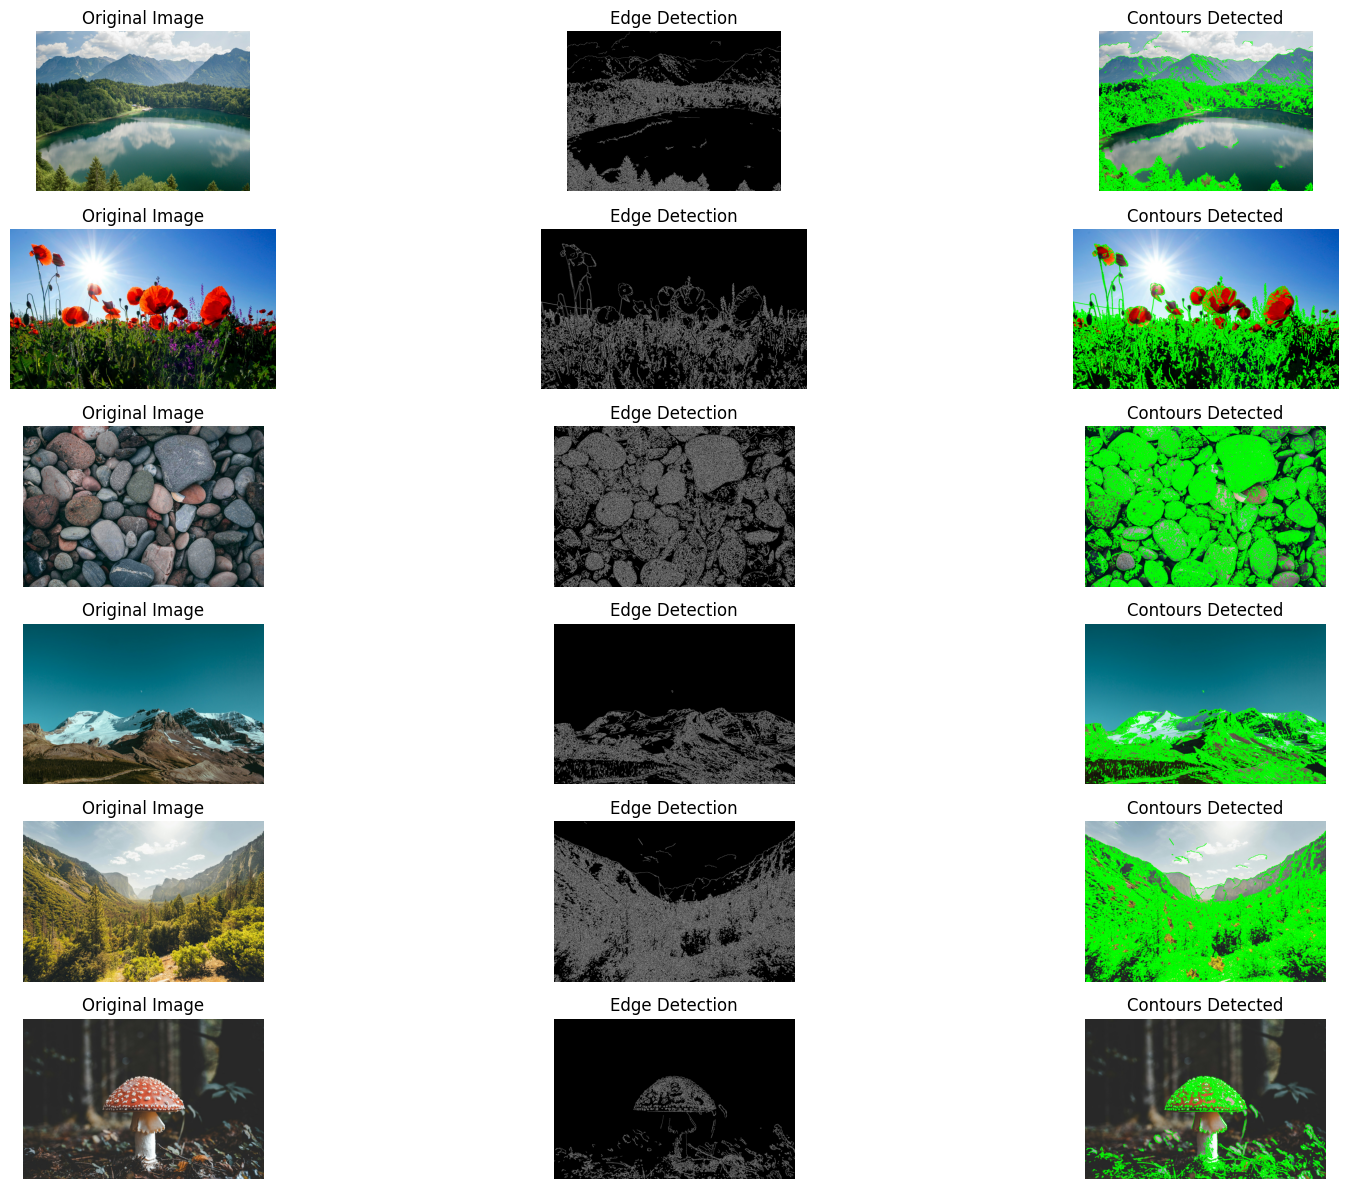

In [46]:
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualizing images
import glob  # Glob to ease file handling (though not used here)

# Defining paths to the uploaded images
# These are the paths where the images are stored
image_paths = [
    "/content/nature_image_1.jpg",
    "/content/nature_image_2.jpg",
    "/content/nature_image_3.jpg",
    "/content/nature_image_4.jpg",
    "/content/nature_image_5.jpg",
    "/content/nature_image_6.jpg"
]

# Function to extract and display contours from an image
def extract_contours(image_path):
    # Load the image from the given path
    img = cv2.imread(image_path)

    # Check if the image is loaded properly
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    # Convert the image to grayscale for better edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection to find edges in the image
    edges = cv2.Canny(gray, 50, 150)  # Thresholds set to 50 and 150

    # Find contours in the edge-detected image
    # RETR_EXTERNAL retrieves only the outer contours
    # CHAIN_APPROX_SIMPLE removes redundant points, compressing the contour
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours
    contour_img = img.copy()

    # Draw detected contours on the copied image in green color
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Green color, thickness=2

    return img, edges, contour_img  # Return the original, edge-detected, and contoured images

# Processing and displaying results for all images
plt.figure(figsize=(18, 12))  # Set figure size for better visualization
for i, image_path in enumerate(image_paths):
    result = extract_contours(image_path)  # Extract contours from each image

    if result is not None:
        img, edges, contour_img = result  # Unpack the returned images

        # Display the original image
        plt.subplot(6, 3, i*3 + 1)  # Creating subplots in a 6-row grid
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        plt.title("Original Image")
        plt.axis("off")  # Hide axes

        # Display the edge-detected image
        plt.subplot(6, 3, i*3 + 2)
        plt.imshow(edges, cmap="gray")  # Show edges in grayscale
        plt.title("Edge Detection")
        plt.axis("off")

        # Display the image with detected contours
        plt.subplot(6, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
        plt.title("Contours Detected")
        plt.axis("off")

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()  # Show all images


Loading each image from the specified file path.

Converting it to grayscale for easier edge detection.

Applying Canny edge detection to find edges.

Finding contours from the detected edges.

Drawing contours on a copy of the original image.

Displaying results side-by-side using Matplotlib.

The edge detection results are generally effective in highlighting the significant features in each image.

The contour detection successfully outlines the main objects, even in images with complex backgrounds.

The green color used for contour overlay provides a clear visual distinction from the original image content.

**Generating a COCO JSON file that contains the bounding boxes and labels for the
extracted contours.**

In [25]:
import cv2  # OpenCV for image processing
import os  # File handling
import json  # Saving annotations in COCO format
import numpy as np  # NumPy for numerical operations
from datetime import datetime  # Timestamping the dataset

# Create an "annotations" directory if it doesn't exist
os.makedirs("annotations", exist_ok=True)

# Defining category labels and their IDs for COCO format
categories = [
    {"id": 0, "name": "mountain", "supercategory": "nature"},
    {"id": 1, "name": "tree", "supercategory": "nature"},
    {"id": 2, "name": "lake", "supercategory": "nature"},
    {"id": 3, "name": "rock", "supercategory": "nature"},
    {"id": 4, "name": "flower", "supercategory": "nature"},
]

# Define paths to uploaded images
image_paths = [
    "/content/nature_image_1.jpg",
    "/content/nature_image_2.jpg",
    "/content/nature_image_3.jpg",
    "/content/nature_image_4.jpg",
    "/content/nature_image_5.jpg",
    "/content/nature_image_6.jpg"
]

# Initialize COCO JSON structure
coco_data = {
    "info": {
        "year": "2025",
        "version": "1",
        "description": "Nature Images",
        "contributor": "Your_Name",
        "url": "URL_Here",
        "date_created": datetime.now().isoformat(),  # Timestamp for dataset creation
    },
    "licenses": [
        {"id": 1, "url": "URL_Here", "name": "Public Domain"}  # License information
    ],
    "categories": categories,  # Defined category labels
    "images": [],  # Placeholder for image metadata
    "annotations": []  # Placeholder for object annotations
}

# Annotation ID counter to keep track of unique annotations
annotation_id = 0

# Function to determine category based on object size and shape
def categorize_object(w, h):
    area = w * h  # Calculate area of the bounding box
    if area > 30000:
        return 0  # "mountain"
    elif area > 10000:
        return 1  # "tree"
    elif w > h * 2:
        return 2  # "lake" (assuming lakes are wider than they are tall)
    elif area > 5000:
        return 3  # "rock"
    else:
        return 4  # "flower"

# Process each image in the dataset
for image_id, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)  # Load the image
    if img is None:
        print(f"Error loading image: {image_path}")
        continue  # Skip to the next image if loading fails

    height, width, _ = img.shape  # Get image dimensions

    # Store image metadata in COCO format
    coco_data["images"].append({
        "id": image_id,
        "license": 1,
        "file_name": os.path.basename(image_path),
        "height": height,
        "width": width,
        "date_captured": datetime.now().isoformat()
    })

    # Convert image to grayscale for edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)  # Apply Canny edge detection

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process each detected contour (potential object)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding box around contour
        area = w * h  # Compute area of bounding box

        # Ignore small noise contours to improve annotation quality
        if area < 500:
            continue

        category_id = categorize_object(w, h)  # Categorize object based on size/shape

        # Store annotation in COCO format
        coco_data["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox": [int(x), int(y), int(w), int(h)],  # Bounding box coordinates
            "area": int(area),
            "segmentation": [],  # Placeholder for segmentation data (not used here)
            "iscrowd": 0  # Assuming no crowded objects
        })

        annotation_id += 1  # Increment annotation counter

# Save the COCO annotations to a JSON file
output_json_path = "annotations/coco_annotations.json"
with open(output_json_path, "w") as json_file:
    json.dump(coco_data, json_file, indent=4)  # Save with indentation for readability

print(f"COCO JSON file saved at: {output_json_path}")


COCO JSON file saved at: annotations/coco_annotations.json


**Saving annotated copies of the original images with the bounding boxes and object
labels clearly drawn.**

repeating the code to save as coco json file

In [26]:
import cv2
import os
import json
import numpy as np
from datetime import datetime

# Creating directories
os.makedirs("annotations", exist_ok=True)
os.makedirs("annotated_images", exist_ok=True)

# Defining category labels and their IDs
categories = [
    {"id": 0, "name": "mountain", "supercategory": "nature"},
    {"id": 1, "name": "tree", "supercategory": "nature"},
    {"id": 2, "name": "lake", "supercategory": "nature"},
    {"id": 3, "name": "rock", "supercategory": "nature"},
    {"id": 4, "name": "flower", "supercategory": "nature"},
]

# Defining paths to the uploaded images
image_paths = [
    "/content/nature_image_1.jpg",
    "/content/nature_image_2.jpg",
    "/content/nature_image_3.jpg",
    "/content/nature_image_4.jpg",
    "/content/nature_image_5.jpg",
    "/content/nature_image_6.jpg"
]

# Initialize COCO JSON structure
coco_data = {
    "info": {
        "year": "2025",
        "version": "1",
        "description": "Nature Images",
        "contributor": "Your_Name",
        "url": "URL_Here",
        "date_created": datetime.now().isoformat(),
    },
    "licenses": [
        {"id": 1, "url": "URL_Here", "name": "Public Domain"}
    ],
    "categories": categories,
    "images": [],
    "annotations": []
}

# Annotation ID counter
annotation_id = 0

# Function to determine category based on object size and shape
def categorize_object(w, h):
    area = w * h
    if area > 30000:
        return 0  # "mountain"
    elif area > 10000:
        return 1  # "tree"
    elif w > h * 2:
        return 2  # "lake"
    elif area > 5000:
        return 3  # "rock"
    else:
        return 4  # "flower"

# Process each image
for image_id, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        continue

    height, width, _ = img.shape

    # Store image info in COCO format
    coco_data["images"].append({
        "id": image_id,
        "license": 1,
        "file_name": os.path.basename(image_path),
        "height": height,
        "width": width,
        "date_captured": datetime.now().isoformat()
    })

    # Convert to grayscale and apply edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process each detected contour
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h

        # Ignore small noise contours
        if area < 500:
            continue

        category_id = categorize_object(w, h)
        category_name = categories[category_id]["name"]

        # Store annotation in COCO format
        coco_data["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox": [int(x), int(y), int(w), int(h)],
            "area": int(area),
            "segmentation": [],
            "iscrowd": 0
        })

        # Draw bounding box and label on the image
        color = (0, 255, 0)  # Green bounding box
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        annotation_id += 1

    # Save annotated image
    annotated_image_path = f"annotated_images/annotated_{os.path.basename(image_path)}"
    cv2.imwrite(annotated_image_path, img)
    print(f"Saved: {annotated_image_path}")

# Save COCO JSON file
output_json_path = "annotations/coco_annotations.json"
with open(output_json_path, "w") as json_file:
    json.dump(coco_data, json_file, indent=4)

print(f"COCO JSON file saved at: {output_json_path}")


Saved: annotated_images/annotated_nature_image_1.jpg
Saved: annotated_images/annotated_nature_image_2.jpg
Saved: annotated_images/annotated_nature_image_3.jpg
Saved: annotated_images/annotated_nature_image_4.jpg
Saved: annotated_images/annotated_nature_image_5.jpg
Saved: annotated_images/annotated_nature_image_6.jpg
COCO JSON file saved at: annotations/coco_annotations.json


the annotated image has been saved in the json file

**grayscale showing only the contour outlines.**

In [27]:
import cv2
import os

# Create output directory
os.makedirs("extracted_contours_greyscale", exist_ok=True)

# uploaded images
image_paths = [
    "/content/nature_image_1.jpg",
    "/content/nature_image_2.jpg",
    "/content/nature_image_3.jpg",
    "/content/nature_image_4.jpg",
    "/content/nature_image_5.jpg",
    "/content/nature_image_6.jpg"
]

# Process each image
for image_path in image_paths:
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        continue

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Create a black background
    black_bg = cv2.bitwise_not(cv2.bitwise_not(edges))

    # Save the processed image
    output_path = f"extracted_contours_greyscale/contours_{os.path.basename(image_path)}"
    cv2.imwrite(output_path, black_bg)
    print(f"Saved: {output_path}")

print("✅ All contour images saved successfully!")


Saved: extracted_contours_greyscale/contours_nature_image_1.jpg
Saved: extracted_contours_greyscale/contours_nature_image_2.jpg
Saved: extracted_contours_greyscale/contours_nature_image_3.jpg
Saved: extracted_contours_greyscale/contours_nature_image_4.jpg
Saved: extracted_contours_greyscale/contours_nature_image_5.jpg
Saved: extracted_contours_greyscale/contours_nature_image_6.jpg
✅ All contour images saved successfully!


grayscale contours of all 6 images has been saved in the extacted_contours_greyscale

**colour filters to the regions inside the major contours**


**Thresholding & Contour-Based Region Coloring**

In [28]:
import cv2
import numpy as np
import os

# Create output directory
os.makedirs("extracted_regions_rgb", exist_ok=True)

# images
image_paths = [
    "/content/nature_image_1.jpg",
    "/content/nature_image_2.jpg",
    "/content/nature_image_3.jpg",
    "/content/nature_image_4.jpg",
    "/content/nature_image_5.jpg",
    "/content/nature_image_6.jpg"
]

# Define color mappings (BGR format)
colors = {
    "mountain": (128, 128, 128),  # Grey
    "lake": (255, 0, 0),          # Blue
    "tree": (0, 100, 0),          # Dark Green
    "rock": (139, 69, 19),        # Brown
    "flower": (180, 105, 255),    # Pink
    "background": (50, 205, 50)   # Light Green
}

# Process each image
for image_path in image_paths:
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        continue

    # Convert to grayscale and find contours
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask
    mask = np.zeros_like(img)

    # Fill major contours with appropriate colors
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area > 1000:  # Ignore small contours
            color = list(colors.values())[i % len(colors)]  # Assign color cyclically
            cv2.drawContours(mask, [cnt], -1, color, thickness=cv2.FILLED)

    # Blend original image and color mask
    result = cv2.addWeighted(img, 0.4, mask, 0.6, 0)

    # Save the processed image
    output_path = f"extracted_regions_rgb/colored_{os.path.basename(image_path)}"
    cv2.imwrite(output_path, result)
    print(f"Saved: {output_path}")

print("✅ All region-colored images saved successfully!")


Saved: extracted_regions_rgb/colored_nature_image_1.jpg
Saved: extracted_regions_rgb/colored_nature_image_2.jpg
Saved: extracted_regions_rgb/colored_nature_image_3.jpg
Saved: extracted_regions_rgb/colored_nature_image_4.jpg
Saved: extracted_regions_rgb/colored_nature_image_5.jpg
Saved: extracted_regions_rgb/colored_nature_image_6.jpg
✅ All region-colored images saved successfully!


since the Thresholding & Contour-Based Region Coloring is


*Simple and fast.


*Good for segmenting high-contrast images with distinct shapes.


*Works poorly for images with complex textures and soft transitions.

*Only detects large, well-defined contours, missing detailed structures.

 I also tried with k means and got good reults in alternative image which didn' get proper output in previous outputs

**K-Means Clustering with Feature Augmentation**

In [30]:
import cv2
import numpy as np
import os
from skimage.segmentation import slic
from sklearn.cluster import KMeans

def advanced_region_coloring_kmeans_features(image_paths, output_dir="extracted_regions_kmeans_features"):
    """
    Applies K-means with feature augmentation for slightly improved results.
    """

    os.makedirs(output_dir, exist_ok=True)

    colors = {
        0: (128, 128, 128),     # Mountain (Grey)
        1: (255, 0, 0),         # Lake (Blue)
        2: (0, 100, 0),         # Tree (Dark Green)
        3: (139, 69, 19),       # Rock (Brown)
        4: (180, 105, 255),     # Flower (Pink)
        5: (135, 206, 235),     # Sky (Light Blue)
        6: (50, 205, 50)        # Background (Light Green)
    }

    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error loading image: {image_path}")
            continue

        segments = slic(img, n_segments=100, compactness=10)
        segmented_img = img.copy()  # Use original image for feature extraction

        # Feature Augmentation (RGB + Pixel Coordinates)
        features = []
        for y in range(segmented_img.shape[0]):
            for x in range(segmented_img.shape[1]):
                features.append(np.concatenate((segmented_img[y, x], [x / segmented_img.shape[1], y / segmented_img.shape[0]])))
        features = np.array(features).astype(np.float32)

        kmeans = KMeans(n_clusters=len(colors), random_state=0, n_init="auto")
        kmeans.fit(features)
        labels = kmeans.labels_.reshape(segmented_img.shape[:2])

        colored_img = img.copy()
        for label_val, color in colors.items():
            mask = (labels == label_val).astype(np.uint8) * 255
            colored_region = np.full_like(img, color)
            colored_img = np.where(mask[..., None] > 0, colored_region, colored_img)

        output_path = os.path.join(output_dir, f"kmeans_features_{os.path.basename(image_path)}")
        cv2.imwrite(output_path, colored_img)
        print(f"Saved: {output_path}")

    print("✅ K-Means with features complete!")


image_paths = [
    "/content/nature_image_1.jpg",
    "/content/nature_image_2.jpg",
    "/content/nature_image_3.jpg",
    "/content/nature_image_4.jpg",
    "/content/nature_image_5.jpg",
    "/content/nature_image_6.jpg"
]

advanced_region_coloring_kmeans_features(image_paths)

Saved: extracted_regions_kmeans_features/kmeans_features_nature_image_1.jpg
Saved: extracted_regions_kmeans_features/kmeans_features_nature_image_2.jpg
Saved: extracted_regions_kmeans_features/kmeans_features_nature_image_3.jpg
Saved: extracted_regions_kmeans_features/kmeans_features_nature_image_4.jpg
Saved: extracted_regions_kmeans_features/kmeans_features_nature_image_5.jpg
Saved: extracted_regions_kmeans_features/kmeans_features_nature_image_6.jpg
✅ K-Means with features complete!



*Works better for images with complex textures and soft edges.

*Feature augmentation (RGB + coordinates) improves segmentation accuracy.

*Does not require predefined contour structures.

*Computationally heavier than the first approach.

Since my execution environment was Google Colab, I didn't implement DeepLab, a highly effective deep learning model for image segmentation. DeepLab leverages advanced techniques like atrous convolution and deep neural networks to achieve precise region extraction, making it ideal for detailed image processing tasks. Instead, I explored alternative segmentation methods to achieve comparable results.